# Import

In [83]:
from __future__ import absolute_import
from __future__ import print_function

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import re
import os
import csv
import sys
import pandas as pd
import numpy as np
import random
from numpy import interp
import matplotlib.pyplot as plt

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import classification_report,confusion_matrix,f1_score,auc,roc_curve,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,confusion_matrix, average_precision_score, matthews_corrcoef
from numpy.random import seed
from inspect import signature

# import keras
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from numpy.random import seed


import torch.nn as nn
import optuna
from torch.utils.data.sampler import WeightedRandomSampler
import torch
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_sequence
from torch.distributions import Normal
import torch.nn.functional as F

from shap import summary_plot
from captum.attr import ShapleyValueSampling, IntegratedGradients, GuidedBackprop
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

#loggging
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)
# Create a custom logger
logger = logging.getLogger()

# Remove existing handlers (important in Jupyter)
logger.handlers.clear()

# Create formatter
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'  # Custom date format
)

# Console handler (output to notebook cell)
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)

# File handler (output to file)
file_handler = logging.FileHandler('logfile.log', mode='w')  # 'w' = overwrite
file_handler.setFormatter(formatter)

# Add both handlers to the logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)

# Log something
logging.debug("Debug message")
logging.info("Info message")
logging.warning("Warning message")
logging.error("Error message")
logging.critical("Critical message")


#setup tqdm
from tqdm import tqdm  # Use tqdm for progress bar in Jupyter
tqdm.pandas()

2025-08-05 09:17:00 - DEBUG - Debug message
2025-08-05 09:17:00 - INFO - Info message
2025-08-05 09:17:00 - WARNING - Warning message
2025-08-05 09:17:00 - ERROR - Error message
2025-08-05 09:17:00 - CRITICAL - Critical message


In [84]:
#read .csv ("../Data extraction/eicu_df_all_24los_normed.csv")
df = pd.read_csv("../Data extraction/eicu_df_all_24los_normed.csv")
# Rename columns to match expected names in columns_ord
df = df.rename(columns={
    'Gender': 'gender',
    'Age': 'age',
    'Heart Rate': 'Heart Rate',
    'O2 Saturation': 'O2 Saturation',
    'Glucose': 'glucose',
    'Temperature (C)': 'Temperature (C)',
    'Sodium': 'sodium',
    'BUN': 'BUN',
    'WBC': 'WBC x 1000',
    'Hemoglobin': 'Hemoglobin',
    'Platelets': 'Platelets',
    'Potassium': 'Potassium',
    'Chloride': 'Chloride',
    'Bicarbonate': 'Bicarbonate',
    'Creatinine': 'Creatinine',
    'CAM': 'CAM',
})

# Class and Methods (new Structure)

In [117]:
# 2. Helper Functions
import traceback

def log_feature_check(arr, expected_features, context):
    actual_features = arr.shape[-1] if arr.ndim >= 3 else None
    if actual_features is not None and actual_features != len(expected_features):
        logging.error(
            f"[{context}] Feature count mismatch: expected {len(expected_features)}, got {actual_features}"
        )
        # Try to infer which feature is missing
        # If arr is a numpy array, try to get column names if possible
        # Otherwise, log indices
        logging.error(f"[{context}] Expected features: {expected_features}")
        # If possible, log a sample row for manual inspection
        if hasattr(arr, 'dtype') and arr.dtype.names:
            logging.error(f"[{context}] Actual columns: {arr.dtype.names}")
        else:
            logging.error(f"[{context}] Cannot determine actual feature names from array shape only.")
    else:
        logging.debug(f"[{context}] Feature count OK: {actual_features}")

class DataHelper:
    """
    Collection of static helper functions for data selection and preprocessing.
    """

    @staticmethod
    def pos_selection(df_pos, skip_time, min_time):
        """
        Selects positive samples for patients who meet the delirium criteria.

        Args:
            df_pos (pd.DataFrame): DataFrame containing positive patient data.
            skip_time (int): Time to skip before prediction window.
            min_time (int): Minimum time window for selection.

        Returns:
            pd.DataFrame: Filtered DataFrame with selected positive samples.
        """
        try:
            posl = []
            posdf = pd.DataFrame(columns=df_pos.columns)
            all_matches = df_pos[df_pos['labelpt'] == df_pos['labelrec']]
            for p_id in all_matches['patientunitstayid'].unique():
                df_p_id = df_pos[df_pos['patientunitstayid'] == p_id]
                idx = all_matches[all_matches['patientunitstayid'] == p_id].index[0]
                t = df_pos.iloc[idx].itemoffset
                if t > (min_time + skip_time):
                    mask = (df_p_id['itemoffset'] < (t - skip_time)) & (df_p_id['itemoffset'] > (t - (skip_time + min_time)))
                    selected = df_p_id[mask]
                    if not selected.empty:
                        posl.append(selected)
            if posl:
                posdf = pd.concat(posl, axis=0)
            return posdf
        except Exception as e:
            logging.error(f"pos_selection failed: {e}")
            return pd.DataFrame(columns=df_pos.columns)

    @staticmethod
    def neg_selection(df_neg, skip_time, min_time):
        """
        Selects negative samples for patients who do not meet the delirium criteria.

        Args:
            df_neg (pd.DataFrame): DataFrame containing negative patient data.
            skip_time (int): Time to skip before prediction window.
            min_time (int): Minimum time window for selection.

        Returns:
            pd.DataFrame: Filtered DataFrame with selected negative samples.
        """
        try:
            negl = []
            negdf = pd.DataFrame(columns=df_neg.columns)
            for p_id in df_neg['patientunitstayid'].unique():
                df_p_id = df_neg[df_neg['patientunitstayid'] == p_id]
                t = df_p_id.iloc[-1].itemoffset
                if t > (min_time + skip_time):
                    mask = (df_p_id['itemoffset'] < (t - skip_time)) & (df_p_id['itemoffset'] > (t - (min_time + skip_time)))
                    selected = df_p_id[mask]
                    if not selected.empty:
                        negl.append(selected)
            if negl:
                negdf = pd.concat(negl, axis=0)
            return negdf
        except Exception as e:
            logging.error(f"neg_selection failed: {e}")
            return pd.DataFrame(columns=df_neg.columns)

    @staticmethod
    def reader_deli(df_list, columns_ord, verbose=1):
        """
        Reads a list of DataFrames and extracts features for each patient.
        Args: 
            df_list (list): List of DataFrames for each patient.
            columns_ord (list): Ordered list of column names to extract.
            verbose (int): Verbosity level for logging.
        Returns:
            tuple: (PID, X_cat, X_noncat, ts, nrows, deli)
        """
        print("\n ---- reader_deli ---- \n")
        try:
            logging.info(f"Start: {len(df_list)} patient DataFrames")
            X_noncat, X_cat, deli, nrows, ts, PID = [], [], [], [], [], []
            skipped_missing = 0
            skipped_empty = 0
            for i, df in enumerate(tqdm(df_list, desc="Processing patients", ascii=" ▖▘▝▗▚▞█" )):
                dft = df
                missing_cols = [c for c in columns_ord if c not in dft.columns]
                if missing_cols:
                    skipped_missing += 1
                    continue
                dummy = pd.DataFrame(columns=columns_ord)
                for c in columns_ord:
                    dummy[c] = dft[c]
                dft = dummy
                narr = np.array(dft)
                if narr.shape[0] == 0:
                    skipped_empty += 1
                    continue
                try:
                    pid = narr[0, 0]
                    x_cat = narr[:, 2:3]
                    x_noncat = narr[:, 3:-1]
                    log_feature_check(
                        x_noncat.reshape(1, x_noncat.shape[0], x_noncat.shape[1]),
                        [
                            'age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose',
                            'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin',
                            'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine'
                        ],
                        context=f"reader_deli patient {i+1}"
                    )
                    labeldeli = narr[0, -1]
                    time = narr[:, 1]
                except Exception as e:
                    logging.error(f"Indexing error for patient {i+1}: {e}")
                    continue
                X_cat.append(x_cat)
                X_noncat.append(x_noncat)
                deli.append(labeldeli)
                ts.append(time)
                nrows.append(narr.shape[0])
                PID.append(pid)
            logging.debug(f"Finished. Skipped missing: {skipped_missing}, skipped empty: {skipped_empty}, processed: {len(PID)}")
            try:
                PID = np.array(PID)
                deli = np.array(deli)
                return PID, X_cat, X_noncat, ts, nrows, deli
            except Exception as e:
                logging.error(f"Array conversion error: {e}")
                return None, None, None, None, None, None
        except Exception as e:
            logging.error(f"Failed: {e}")
            return None, None, None, None, None, None
    
    @staticmethod
    def pad(arr, max_len):
        try:
            if arr.ndim == 1:
                tmp = np.zeros((max_len,))
                tmp[:arr.shape[0]] = arr
            else:
                tmp = np.zeros((max_len, arr.shape[1]))
                tmp[:arr.shape[0], :arr.shape[1]] = arr
            return tmp
        except Exception as e:
            logging.error(f"[pad] Failed: {e}")
            if arr.ndim == 1:
                return np.zeros((max_len,))
            else:
                return np.zeros((max_len, arr.shape[1]))
    
    @staticmethod
    def ret_numpy(X, max_len, feature_type="unknown"):
        try:
            arr = np.array([DataHelper.pad(n, max_len) for n in X])
            if arr.ndim == 3 and arr.shape[2] > 0:
                logging.info(f"[DATA] {feature_type} feature unique after pad: {np.unique(arr[...,0])[:10]}")
                # Only check for numerical features
                if feature_type == "numerical":
                    log_feature_check(
                        arr,
                        [
                            'age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose',
                            'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin',
                            'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine'
                        ],
                        context=f"ret_numpy ({feature_type})"
                    )
            return arr
        except Exception as e:
            logging.error(f"[ret_numpy] Failed: {e}")
            return np.array([])
    
    @staticmethod
    def get_class_weights(data, label):
        """
        Computes class weights for imbalanced datasets.

        Args:
            data (np.ndarray): Data array.
            label (np.ndarray): Label array.

        Returns:
            tuple: (weight_for_0, weight_for_1)
        """
        try:
            neg = data[label == 0].shape[0]
            pos = len(data) - neg
            if neg == 0 or pos == 0:
                raise ValueError("No samples for one of the classes.")
            weight_for_0 = (1 / neg) * ((pos + neg)) / 2.0
            weight_for_1 = (1 / pos) * ((pos + neg)) / 2.0
            return weight_for_0, weight_for_1
        except Exception as e:
            print(f"[ERROR] get_class_weights failed: {e}")
            return 1.0, 1.0

    @staticmethod
    def sampler_fn(data, label):
        """
        Creates a weighted random sampler for balanced training.

        Args:
            data (np.ndarray): Data array.
            label (np.ndarray): Label array.

        Returns:
            WeightedRandomSampler: Sampler for DataLoader.
        """
        try:
            import torch
            from torch.utils.data.sampler import WeightedRandomSampler
            train_class_sample_count = torch.tensor([(torch.tensor(label) == t).sum() for t in torch.unique(torch.tensor(label), sorted=True)])
            train_weight = 1 / train_class_sample_count.float()
            train_samples_weight = torch.tensor([train_weight[i] for i in torch.tensor(label).long()])
            train_sampler = WeightedRandomSampler(train_samples_weight, len(train_samples_weight))
            return train_sampler
        except Exception as e:
            print(f"[ERROR] sampler_fn failed: {e}")
            return

# 3. Data Loading and Preprocessing

def load_eicu_data(min_time, skip_time, data_path="V:\\delirium\\Delirium_prediction_models\\Data extraction\\eicu_df_all_24los_normed.csv"):
    print("\n ---- load_eicu_data ---- \n")
    try:
        # Check if file exists before reading
        if not os.path.exists(data_path):
            logging.error(f"[ERROR] File does not exist: {data_path}")
            return [], []
        df = pd.read_csv(data_path)
        logging.debug(f"[DATA] gender unique after load: {df['Gender'].unique()[:10]}")
    
        # Check for expected columns
        expected_cols = ['CAM']
        for col in expected_cols:
            if col not in df.columns:
                logging.error(f"[ERROR] Expected column missing: {col}")
                return [], []

        pos_df = df[df['CAM'] == 1]
        neg_df = df[df['CAM'] == 0]
        logging.debug(f"[DATA] gender unique in pos_df: {pos_df['Gender'].unique()[:10]}")
        logging.debug(f"[DATA] gender unique in neg_df: {neg_df['Gender'].unique()[:10]}")
        
        pos_filtered = DataHelper.pos_selection(pos_df, skip_time, min_time)
        neg_filtered = DataHelper.neg_selection(neg_df, skip_time, min_time)

        df_filtered = pd.concat([pos_filtered, neg_filtered], axis=0)
        logging.info(f"[DATA] gender unique after filtering: {df_filtered['Gender'].unique()[:10]}")
   
        ##### DEBUGING #####
        # After filtering, before grouping
        logging.debug(f" pos_filtered shape: {pos_filtered.shape}")
        logging.debug(f" neg_filtered shape: {neg_filtered.shape}")
        logging.debug(f" df_filtered shape: {df_filtered.shape}")

        group_sizes = df_filtered.groupby('patientunitstayid').size()
        zero_row_patients = group_sizes[group_sizes == 0].index.tolist()

        all_nan_patients = []
        for pid, group in df_filtered.groupby('patientunitstayid'):
            if group.isnull().all(axis=None):
                all_nan_patients.append(pid)

        logging.debug(f" After filtering: total patients: {df_filtered['patientunitstayid'].nunique()}")
        logging.debug(f" After filtering: patients with zero rows: {len(zero_row_patients)}")
        logging.debug(f" After filtering: patients with all-NaN rows: {len(all_nan_patients)}")
        logging.debug(f" Number of rows for the patient with the most rows: {df_filtered['patientunitstayid'].value_counts().max()}")
        ##### END DEBUGGING #####
        df_filtered = df_filtered.rename(columns={
            'Gender': 'gender',
            'Age': 'age',
            'Heart Rate': 'Heart Rate',
            'O2 Saturation': 'O2 Saturation',
            'Glucose': 'glucose',
            'Temperature (C)': 'Temperature (C)',
            'Sodium': 'sodium',
            'BUN': 'BUN',
            'WBC': 'WBC x 1000',
            'Hemoglobin': 'Hemoglobin',
            'Platelets': 'Platelets',
            'Potassium': 'Potassium',
            'Chloride': 'Chloride',
            'Bicarbonate': 'Bicarbonate',
            'Creatinine': 'Creatinine',
            'CAM': 'CAM',
        })

        grouped = df_filtered.groupby('patientunitstayid')
        train_np = [frame for _, frame in grouped]

        columns_ord = [
            'patientunitstayid', 'itemoffset', 'gender', 'age', 'Height', 'Weight',
            'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN',
            'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine',
            # 'vent_flag', 'vaso_dose', 'sofa', 'sofa_wo_gcs'
            'CAM'
        ]
        logging.debug(f"columns_ord: {columns_ord}")
        return train_np, columns_ord
    except Exception as e:
        logging.error(f"[ERROR] load_eicu_data failed: {e}\n{traceback.format_exc()}")
        return [], []

def select_pos_neg(df, skip_time, min_time):
    print("\n ---- select_pos_neg ---- \n")
    """
    Splits a DataFrame into positive and negative samples using helper functions.

    Args:
        df (pd.DataFrame): Input DataFrame.
        skip_time (int): Time to skip before prediction window.
        min_time (int): Minimum time window for selection.

    Returns:
        tuple: (pos_filtered, neg_filtered)
    """
    try:
        pos_df = df[df['CAM'] == 1]
        neg_df = df[df['CAM'] == 0]
        pos_filtered = DataHelper.pos_selection(pos_df, skip_time, min_time)
        neg_filtered = DataHelper.neg_selection(neg_df, skip_time, min_time)
        return pos_filtered, neg_filtered
    except Exception as e:
        print(f"[ERROR] select_pos_neg failed: {e}")
        return pd.DataFrame(),

# 4. Model Definition
class BiRNN(nn.Module):
    """
    Bidirectional LSTM model for time-series classification.
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes, drp):
        super(BiRNN, self).__init__()
        self.num_layers  = num_layers
        self.num_classes = num_classes
        self.drop = nn.Dropout(p=drp)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # 2 for bidirection
        self.sigmoid = nn.Sigmoid()
        self.embeds = nn.Embedding(2, 2)
        self.hidden_size = hidden_size

    def forward(self, x_num, x_cat, seq_lengths):
        embed = self.embeds(x_cat).reshape((x_cat.size(0), x_cat.size(1), -1))
        x = torch.cat((x_num, embed), -1)
        out, _ = self.lstm(x)
        lstm_out = out[:, -1, :]
        output = self.fc(lstm_out)
        return output

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        attn_output, attn_weights = self.attention(x, x, x)
        return attn_output, attn_weights

class DSA(nn.Module):
    def __init__(self, num_vars, num_timesteps, num_categorical, cat_embed_dim, input_dim, hidden_dim, num_heads):
        super().__init__()
        self.cat_embedding = nn.Embedding(num_categorical, cat_embed_dim)
        self.input_dim = input_dim + cat_embed_dim

        # Self-attention over variables
        self.var_attention = MultiHeadSelfAttention(self.input_dim, num_heads)
        # Self-attention over time
        self.time_attention = MultiHeadSelfAttention(self.input_dim, num_heads)

        # BiLSTM
        self.bilstm = nn.LSTM(self.input_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Output layer
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_num, x_cat, seq_lengths=None):

        # Squeeze last dim if it's 1, so embedding works
        if x_cat.dim() == 3 and x_cat.shape[-1] == 1:
            x_cat = x_cat.squeeze(-1)

        # Now embed categorical
        if x_cat.dim() == 2:
            x_cat = self.cat_embedding(x_cat)  # (batch, time, embed_dim)
        elif x_cat.dim() == 1:
            x_cat = x_cat.unsqueeze(1)
            x_cat = self.cat_embedding(x_cat)

        x = torch.cat([x_num, x_cat], dim=-1)

        # Variable-level attention
        x_var_attn, _ = self.var_attention(x)  # (batch, time, input_dim)

        # Time-step-level attention
        x_time_attn, _ = self.time_attention(x)  # (batch, time, input_dim)

        # Combine attentions (element-wise product)
        x_combined = x_var_attn * x_time_attn

        # BiLSTM
        lstm_out, _ = self.bilstm(x_combined)  # (batch, time, hidden_dim*2)
        lstm_out = lstm_out[:, -1, :]  # Take last time step

        # Output
        out = self.fc(lstm_out)
        return self.sigmoid(out)

# 5. Training and Evaluation
def train_model(model, data_loader, criterion, optimizer, device, epochs=50, cat_indices=None):
    """
    Trains the BiRNN or DSA model.
    """
    model.to(device)
    epoch_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for (x_num, x_cat), labels in data_loader:
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            labels = labels.to(device)
            # Model-specific forward
            if hasattr(model, "bilstm"):  # DSA model
                labels = labels.float()
                outputs = model(x_num, x_cat.long())
                outputs = outputs.squeeze(-1)  # (batch,)
                loss = criterion(outputs, labels)
            else:  # BiRNN model
                labels = labels.long()
                # Compute sequence lengths for packing
                nonzeros = ~x_num.cpu().numpy().any(axis=2)
                nonzero_index = np.argmax(nonzeros, axis=1)
                nonzero_index = torch.LongTensor(nonzero_index)
                nonzero_index = torch.where(nonzero_index == 0, torch.LongTensor([x_num.size(1)]), nonzero_index)
                seq_lengths, perm_idx = nonzero_index.sort(0, descending=True)
                x_num = x_num[perm_idx]
                x_cat = x_cat[perm_idx]
                labels = labels[perm_idx]
                outputs = model(x_num, x_cat.long(), seq_lengths)
                loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(data_loader)
        epoch_losses.append(epoch_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs - 1:
            logging.debug(f"Epoch: {epoch+1}/{epochs} Training Loss: {epoch_loss:.3f}")
    return model, epoch_losses

def evaluate_model(model, data_loader, device, cat_indices=None):
    """
    Evaluates the BiRNN or DSA model.
    """
    model.eval()
    true_labels, pred_probs = [], []
    with torch.no_grad():
        for (x_num, x_cat), labels in data_loader:
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            labels = labels.to(device).long()
            # Model-specific forward
            if hasattr(model, "bilstm"):  # DSA model
                outputs = model(x_num, x_cat.long())
                pred = outputs.detach().cpu().numpy().squeeze(-1)
            else:  # BiRNN model
                # Compute sequence lengths for packing
                nonzeros = ~x_num.cpu().numpy().any(axis=2)
                nonzero_index = np.argmax(nonzeros, axis=1)
                nonzero_index = torch.LongTensor(nonzero_index)
                nonzero_index = torch.where(nonzero_index == 0, torch.LongTensor([x_num.size(1)]), nonzero_index)
                seq_lengths, perm_idx = nonzero_index.sort(0, descending=True)
                x_num = x_num[perm_idx]
                x_cat = x_cat[perm_idx]
                labels = labels[perm_idx]
                outputs = nn.Softmax(dim=1)(model(x_num, x_cat.long(), seq_lengths))
                pred = outputs.detach().cpu().numpy()[:, 1]
            true_labels.extend(labels.cpu().numpy())
            pred_probs.extend(pred)
    return np.array(true_labels), np.array(pred_probs)

def cross_validate(X_num, X_cat, y, params, batch_size, device, sampler_fn, get_class_weights, overdata, epochs=50, n_splits=5, cat_indices=None, model_cls=None, model_args=None, model_name=None):
    """
    Performs cross-validation for the given model class.
    Args:
        X_num (np.ndarray): Numerical feature array.
        X_cat (np.ndarray): Categorical feature array.
        y (np.ndarray): Label array.
        params (dict): Model parameters.
        batch_size (int): Batch size.
        device: Device to train/evaluate on.
        sampler_fn: Function to create sampler.
        get_class_weights: Function to get class weights.
        overdata: Dataset class.
        epochs (int): Number of epochs.
        n_splits (int): Number of CV folds.
        cat_indices (list): Indices of categorical features.
        model_cls (class): Model class to instantiate.
    Returns:
        dict: Cross-validation metrics.
    """
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=36)
    cv_scores = {}
    all_fold_losses = []
    for i, (train_idx, test_idx) in tqdm(
        enumerate(kfold.split(X_num, y), 1),
        desc="Cross-validation",
        ascii=" ▖▘▝▗▚▞█",
        total=n_splits
    ):
        logging.debug(f'Fold: {i}')
        X_tr_num, X_tr_cat = X_num[train_idx], X_cat[train_idx]
        X_ts_num, X_ts_cat = X_num[test_idx], X_cat[test_idx]
        y_tr, y_ts = y[train_idx], y[test_idx]
        data_sampler = sampler_fn(X_tr_num, y_tr)
        train_data = overdata(X_tr_num, X_tr_cat, y_tr)
        test_data = overdata(X_ts_num, X_ts_cat, y_ts)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, sampler=data_sampler)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        cw_0, cw_1 = get_class_weights(X_tr_num, y_tr)
        model = model_cls(**model_args).to(device)
        # Select correct loss function
        if model_cls.__name__ == "DSA":
            criterion = nn.BCELoss()
        else:
            criterion = nn.CrossEntropyLoss(weight=torch.Tensor([cw_0, cw_1]).to(device))
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=1e-6)
        model, fold_losses = train_model(model, train_loader, criterion, optimizer, device, epochs, cat_indices=cat_indices)
        all_fold_losses.append(fold_losses)
        savepath = f"eicu_{model_name}_{params['input_size']}_{params['hidden_units']}_fold_{i}_cv_torch.pt"
        torch.save(model.state_dict(), savepath)
        logging.debug(f"Model:{savepath} saved.")
        y_true, y_pred = evaluate_model(model, test_loader, device, cat_indices=cat_indices)
        cv_scores[i] = {'y_true': y_true, 'y_pred': y_pred}
    return cv_scores, all_fold_losses

# 6. Plotting and Metrics

def plot_auc(result):
    """
    Plots the mean ROC curve with standard deviation shading.

    Args:
        result (dict): Dictionary containing ROC metrics.
    """
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Random', alpha=.8)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = result['tpr']
    mean_auc = result['mean_auc']
    std_auc = result['std_auc']
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    std_tpr = result['std_tpr']
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def plot_cum_auc(x_y, models, savename='plot.png', x_label='False Positive Rate', y_label='True Positive Rate', auprc=False, thr=0):
    """
    Plots cumulative ROC or PR curves for multiple models.

    Args:
        x_y (list): List of (x, y) tuples for each model.
        models (list): List of model names.
        savename (str): Filename to save the plot.
        x_label (str): Label for x-axis.
        y_label (str): Label for y-axis.
        auprc (bool): If True, plot PR curve.
        thr (float): Threshold for random line.
    """
    colors = ['b', 'r', 'g']
    for i, (x_y_tuple, m) in enumerate(zip(x_y, models)):
        plt.plot(x_y_tuple[0], x_y_tuple[1], label='{}: {:.4f}'.format(m, auc(x_y_tuple[0], x_y_tuple[1])), color=colors[i])
    if auprc:
        plt.plot([0, 1], [thr, thr], linestyle='--', lw=2, color='k', label="Random: {:.4f}".format(thr), alpha=.8)
    else:
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label="Random: {:.4f}".format(0.5000), alpha=.8)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    if auprc:
        legend = plt.legend(loc="upper left", prop={'size': 10}, bbox_to_anchor=(0.6, 0.95))
    else:
        legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1, 0.05))
    #add title
    plt.title('Cumulative ROC/PR Curves', fontsize=15)
    plt.savefig(savename, dpi=400, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

def compute_metrics(X_test, y_test, y_probs):
    """
    Computes ROC, PR, and other metrics.

    Args:
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): True labels.
        y_probs (np.ndarray): Predicted probabilities.

    Returns:
        dict: Metrics including ROC, PR, AUC, PPV, NPV, MCC, etc.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    specat90 = 1 - fpr[tpr >= 0.90][0]
    intrp = interp(np.linspace(0, 1, 100), fpr, tpr)
    intrp[0] = 0.0
    roc_auc = auc(fpr, tpr)
    TN, FP, FN, TP = confusion_matrix(y_test, y_probs.round()).ravel()
    PPV = TP / (TP + FP) if (TP + FP) > 0 else 0
    NPV = TN / (TN + FN) if (TN + FN) > 0 else 0
    mcc = matthews_corrcoef(y_test, y_probs.round())
    average_precision = average_precision_score(y_test, y_probs)
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    prs = interp(np.linspace(0, 1, 100), recall[::-1], precision[::-1])
    prs[0] = 1.0
    prs[-1] = 0.0
    auc_prc = auc(recall, precision)
    return {
        'specat90': specat90,
        'intrp': intrp,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'ppv': PPV,
        'npv': NPV,
        'auc_prc': auc_prc,
        'prc': precision,
        'prs': prs,
        'rec': recall,
        'mcc': mcc
    }

def avg_metrics(results):
    """
    Averages metrics across CV folds.

    Args:
        results (dict): Metrics per fold.

    Returns:
        dict: Averaged metrics.
    """
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)
    mean_tpr = np.mean([results[k]['intrp'] for k in results], axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std([results[k]['intrp'] for k in results], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std([results[k]['auc'] for k in results])
    ppvs = np.mean([results[k]['ppv'] for k in results])
    npvs = np.mean([results[k]['npv'] for k in results])
    mccs = np.mean([results[k]['mcc'] for k in results])
    specat90 = np.mean([results[k]['specat90'] for k in results])
    mean_precision = np.mean([results[k]['prs'] for k in results], axis=0)
    mean_precision[-1] = 0.0
    mean_precision[0] = 1.0
    mean_auc_prc = auc(mean_recall, mean_precision)
    std_auc_prc = np.std([results[k]['auc_prc'] for k in results], axis=0)
    print("Mean AUC: {0:0.4f} +- STD{1:0.4f}".format(mean_auc, std_auc))
    print("PPV: {0:0.4f}".format(ppvs))
    print("NPV: {0:0.4f}".format(npvs))
    print("MCC: {0:0.4f}".format(mccs))
    print("Spec@90: {0:0.4f}".format(specat90))
    return {
        'mean_auc': mean_auc,
        'tpr': mean_tpr,
        'std_auc': std_auc,
        'std_tpr': std_tpr,
        'ppv': ppvs,
        'npv': npvs,
        'mean_auc_prc': mean_auc_prc,
        'std_auc_prc': std_auc_prc,
        'mean_prc': mean_precision,
        'mean_recall': mean_recall,
        'mcc': mccs,
        'spec@90': specat90
    }

# 7. Interpretability

def get_baseline(X, y, min_time=24, cat_indices=None):
    total_features = X.shape[-1]
    if cat_indices is None:
        raise ValueError("cat_indices must be provided for dynamic baseline construction.")
    num_cat = len(cat_indices)
    num_num = total_features
    logging.debug(f"[get_baseline] total_features: {total_features}, num_num: {num_num}, num_cat: {num_cat}, cat_indices: {cat_indices}")
    # Log which features are being used for numerical
    all_features = [
        'age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose',
        'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin',
        'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine', 'gender'
    ]
    num_features = [f for i, f in enumerate(all_features) if i+3 not in cat_indices]  # +3 offset for columns_ord
    logging.debug(f"[get_baseline] Numerical features used: {num_features}")
    baseline_num = torch.zeros(X.shape[0], min_time, num_num)
    baseline_cat = torch.zeros(X.shape[0], min_time, num_cat)
    m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    baseline_num_gaus = m.sample((X.shape[0], min_time, num_num)).squeeze()
    baseline_num_unif = torch.FloatTensor(X.shape[0], min_time, num_num).uniform_(0, 1)
    baseline_num = (baseline_num_gaus + baseline_num_unif) / 2
    logging.debug(f"[get_baseline] baseline_num shape: {baseline_num.shape}, baseline_cat shape: {baseline_cat.shape}")
    logging.debug(f"[get_baseline] baseline_num min/max: {baseline_num.min().item():.4f}/{baseline_num.max().item():.4f}")
    x_baseline = torch.cat((baseline_num, baseline_cat), -1)
    y_baseline = torch.ones(X.shape[0])
    x_baseline = x_baseline.cpu().numpy()
    y_baseline = y_baseline.cpu().numpy()
    logging.debug(f"[get_baseline] x_baseline shape: {x_baseline.shape}, y_baseline shape: {y_baseline.shape}")
    # Check final baseline shape
    log_feature_check(
        x_baseline,
        [
            'age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose',
            'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin',
            'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine'
        ] + ['gender'],
        context="get_baseline (final)"
    )
    return x_baseline, y_baseline

def get_dynamic_baseline(numerical, categorical):
    logging.debug(f"[get_dynamic_baseline] Called with numerical shape: {numerical.shape}, categorical shape: {categorical.shape}")
    batch_size, seq_len, num_numerical = numerical.shape
    num_categorical = categorical.shape[-2] if categorical.shape[-2] > 0 else 0
    embed_dim = categorical.shape[-1] if num_categorical > 0 else 0

    # Numerical baseline
    if num_numerical > 0:
        m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        baseline_num_gaus = m.sample((batch_size, seq_len, num_numerical)).squeeze()
        baseline_num_unif = torch.FloatTensor(batch_size, seq_len, num_numerical).uniform_(0, 1)
        baseline_num = (baseline_num_gaus + baseline_num_unif) / 2
        logging.debug(f"[get_dynamic_baseline] baseline_num shape: {baseline_num.shape}, min/max: {baseline_num.min().item():.4f}/{baseline_num.max().item():.4f}")
    else:
        baseline_num = torch.empty(batch_size, seq_len, 0)
        logging.debug(f"[get_dynamic_baseline] baseline_num is empty.")

    # Categorical baseline (all zeros, same shape as categorical)
    if num_categorical > 0:
        baseline_cat = torch.zeros(batch_size, seq_len, num_categorical, embed_dim)
        logging.debug(f"[get_dynamic_baseline] baseline_cat shape: {baseline_cat.shape}")
    else:
        baseline_cat = torch.empty(batch_size, seq_len, 0, embed_dim)
        logging.debug(f"[get_dynamic_baseline] baseline_cat is empty.")

    return baseline_num, baseline_cat

def get_feature_ranking_for_shap(model, test_loader, base_loader, alg, device, min_time, cat_indices, embedding_layer_name="embeds"):
    interpretable_embedding = configure_interpretable_embedding_layer(model, embedding_layer_name)
    total_attr_cat, total_attr_num, X_ts_mask, data_ = [], [], [], []
    model.train()
    
    if hasattr(model, "bilstm"):  # DSA model
        target_idx = 0  # Single output, use index 0
    else:  # BiRNN model
        target_idx = 1  # Two outputs, use index 1 for positive class

    # Select explainer based on algorithm
    if alg == "GB":
        explainer = GuidedBackprop(model)
    elif alg == "IG":
        explainer = IntegratedGradients(model)
    elif alg == "SVS":
        explainer = ShapleyValueSampling(model)
    
    # Get sample batch to examine dimensions
    (x_num_sample, x_cat_sample), _ = next(iter(test_loader))
    x_num_sample = x_num_sample.to(device)
    x_cat_sample = x_cat_sample.to(device)
    
    # Debug input dimensions
    logging.debug(f"[get_feature_ranking_for_shap] x_num shape: {x_num_sample.shape}, dtype: {x_num_sample.dtype}")
    logging.debug(f"[get_feature_ranking_for_shap] x_cat shape: {x_cat_sample.shape}, dtype: {x_cat_sample.dtype}")
    log_feature_check(
        x_num_sample.cpu().numpy(),
        [
            'age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose',
            'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin',
            'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine'
        ],
        context="get_feature_ranking_for_shap (x_num_sample)"
    )
    # Get model properties for debugging
    if hasattr(model, "lstm"):
        logging.debug(f"[get_feature_ranking_for_shap] BiRNN expected input_size: {model.lstm.input_size}")
        embed_dim = model.embeds.embedding_dim
        logging.debug(f"[get_feature_ranking_for_shap] BiRNN embedding dim: {embed_dim}")
    elif hasattr(model, "bilstm"):
        logging.debug(f"[get_feature_ranking_for_shap] DSA input_dim: {model.input_dim}")
        embed_dim = model.cat_embedding.embedding_dim
        logging.debug(f"[get_feature_ranking_for_shap] DSA embedding dim: {embed_dim}")
    
    # Process each batch
    for ((x_num, x_cat), labels), ((x_num_base, x_cat_base), labels_base) in tqdm(
        zip(test_loader, base_loader), 
        desc="Explaining features", 
        ascii=" ▖▘▝▗▚▞█ "
    ):
        # Move tensors to device
        x_num = x_num.to(device)
        x_cat = x_cat.to(device)
        labels = labels.to(device)
        x_num_base = x_num_base.to(device)
        x_cat_base = x_cat_base.to(device)
        labels_base = labels_base.to(device)
        
        # Prepare sequence lengths
        nonzeros = ~x_num.cpu().numpy().any(axis=2)
        nonzero_index = np.argmax(nonzeros, axis=1)
        nonzero_index = torch.LongTensor(nonzero_index)
        nonzero_index = torch.where(nonzero_index == 0, torch.LongTensor([min_time]), nonzero_index)
        seq_lengths, perm_idx = nonzero_index.sort(0, descending=True)
        
        # Sort data
        x_num = x_num[perm_idx]
        x_cat = x_cat[perm_idx]
        labels = labels[perm_idx]
        x_num_base = x_num_base[perm_idx]
        x_cat_base = x_cat_base[perm_idx]
        labels_base = labels_base[perm_idx]
        
        # Create mask for padding
        X_ts_bool = np.all(x_num.cpu().numpy() == 0, axis=2)
        X_ts_mask.append(X_ts_bool)
        
        # Handle categorical features for embedding
        if x_cat.dim() == 3 and x_cat.shape[2] == 1:
            x_cat = x_cat.squeeze(2)  # Remove last dimension if it's 1
        if x_cat_base.dim() == 3 and x_cat_base.shape[2] == 1:
            x_cat_base = x_cat_base.squeeze(2)
        
        logging.debug(f"x_cat shape: {x_cat.shape}, dtype: {x_cat.dtype}")
        logging.debug(f"x_cat_base shape: {x_cat_base.shape}, dtype: {x_cat_base.dtype}")

        # Ensure both are indices and same shape
        if x_cat_base.shape != x_cat.shape:
            logging.error(f"Shape mismatch: x_cat shape {x_cat.shape}, x_cat_base shape {x_cat_base.shape}")
        if x_cat_base.dtype != torch.long:
            logging.error(f"x_cat_base dtype is {x_cat_base.dtype}, expected torch.long")

        x_cat_embed = interpretable_embedding.indices_to_embeddings(x_cat.long())
        x_cat_base_embed = interpretable_embedding.indices_to_embeddings(x_cat_base.long())

        logging.debug(f"x_cat_embed shape: {x_cat_embed.shape}, x_cat_base_embed shape: {x_cat_base_embed.shape}")

        # Apply interpretable embedding
        x_cat_embed = interpretable_embedding.indices_to_embeddings(x_cat.long())
        x_cat_base_embed = interpretable_embedding.indices_to_embeddings(x_cat_base.long())
        
        logging.debug(f"[get_feature_ranking_for_shap] x_num shape: {x_num.shape}, x_cat_embed shape: {x_cat_embed.shape}")
        
        # Check if dimensions match model's expected input size
        if hasattr(model, "lstm"):
            expected_size = model.lstm.input_size
            actual_size = x_num.shape[2] + x_cat_embed.shape[2]
            logging.debug(f"[get_feature_ranking_for_shap] Expected input size: {expected_size}, actual size: {actual_size}")
            # Log the shapes of all tensors that will be concatenated
            logging.debug(f"[get_feature_ranking_for_shap] x_num last dim: {x_num.shape[2]}, x_cat_embed last dim: {x_cat_embed.shape[2]}")
            # Log the shape of the baseline tensors
            logging.debug(f"[get_feature_ranking_for_shap] x_num_base shape: {x_num_base.shape}, x_cat_base_embed shape: {x_cat_base_embed.shape}")
            # Log the shape of the inputs tuple for SVS
            logging.debug(f"[get_feature_ranking_for_shap] SVS inputs shapes: x_num: {x_num.shape}, x_cat_embed: {x_cat_embed.shape}")
            logging.debug(f"[get_feature_ranking_for_shap] SVS baselines shapes: x_num_base: {x_num_base.shape}, x_cat_base_embed: {x_cat_base_embed.shape}")
            if expected_size != actual_size:
                logging.warning(f"[get_feature_ranking_for_shap] Dimension mismatch: expected {expected_size}, got {actual_size}")
        
        # Compute attributions based on algorithm
        try:
            if alg == "GB":
                attr_num, attr_cat = explainer.attribute(
                    inputs=(x_num, x_cat_embed),
                    additional_forward_args=seq_lengths,
                    target=target_idx
                )
            elif alg == "IG":
                # For IG, create zero baselines with the same shape as inputs
                x_num_zero = torch.zeros_like(x_num)
                x_cat_zero_embed = torch.zeros_like(x_cat_embed)
                
                # Log shapes to verify
                logging.debug(f"IG zero baselines - x_num_zero: {x_num_zero.shape}, x_cat_zero_embed: {x_cat_zero_embed.shape}")
                
                attr_num, attr_cat = explainer.attribute(
                    inputs=(x_num, x_cat_embed),
                    baselines=(x_num_zero, x_cat_zero_embed),
                    additional_forward_args=seq_lengths,
                    target=target_idx
                )
            elif alg == "SVS":
                # Log before calling SVS
                logging.debug(f"Calling SVS explainer.attribute with:")
                logging.debug(f"  inputs: x_num {x_num.shape}, x_cat_embed {x_cat_embed.shape}")
                logging.debug(f"  baselines: x_num_base {x_num_base.shape}, x_cat_base_embed {x_cat_base_embed.shape}")
                
                # FIX: Adjust baseline shape for SVS
                if x_num_base.shape[2] != x_num.shape[2]:
                    logging.info(f"Correcting x_num_base shape for SVS: {x_num_base.shape} -> {x_num.shape}")
                    # Slice the baseline to match the input shape
                    x_num_base = x_num_base[:, :, :x_num.shape[2]]
                    logging.debug(f"  corrected baselines: x_num_base {x_num_base.shape}, x_cat_base_embed {x_cat_base_embed.shape}")
                
                attr_num, attr_cat = explainer.attribute(
                    inputs=(x_num, x_cat_embed),
                    baselines=(x_num_base, x_cat_base_embed),
                    additional_forward_args=seq_lengths,
                    target=target_idx
                )
            
            # Collect results
            total_attr_cat.append(attr_cat.detach().cpu().numpy())
            total_attr_num.append(attr_num.detach().cpu().numpy())
            
            # Store the combined data for visualization
            if x_cat.dim() == 2:  # Need to add feature dimension
                combined_data = torch.cat((x_num, x_cat.unsqueeze(-1)), dim=2).detach().cpu().numpy()
            else:
                combined_data = torch.cat((x_num, x_cat), dim=2).detach().cpu().numpy()
            data_.append(combined_data)
            
        except Exception as e:
            logging.error(f"[get_feature_ranking_for_shap] Attribution error: {e}")
            logging.error(f"x_num shape: {x_num.shape}, x_cat shape: {x_cat.shape}, x_cat_embed shape: {x_cat_embed.shape}")
            if hasattr(model, "lstm"):
                logging.error(f"BiRNN input_size: {model.lstm.input_size}")
            elif hasattr(model, "bilstm"):
                logging.error(f"DSA input_dim: {model.input_dim}")
            # Log the actual input to LSTM
            try:
                x = torch.cat((x_num, x_cat_embed), -1)
                logging.error(f"Input to LSTM shape: {x.shape}")
            except Exception as concat_e:
                logging.error(f"Error during concatenation: {concat_e}")
            raise
    
    # Clean up and restore model
    remove_interpretable_embedding_layer(model, interpretable_embedding)
    
    # Process attribution results
    if total_attr_cat and total_attr_num:
        total_attr_cat = np.vstack(total_attr_cat)
        # REMOVE THIS LINE: total_attr_cat = np.mean(total_attr_cat, axis=-1)
        total_attr_num = np.vstack(total_attr_num)
        X_ts_mask = np.vstack(X_ts_mask)
        
        # Combine numerical and categorical attributions
        total_attr = np.concatenate([total_attr_num, total_attr_cat], axis=-1)
        total_attr[X_ts_mask] = np.nan  # Mask padded values
        
        # Average across time dimension to get feature importance
        feature_imp = np.nanmean(total_attr, axis=1)
        data_for_shap = np.vstack(data_)
        
        return feature_imp, data_for_shap
    else:
        logging.error("No attribution data collected!")
        return np.array([]), np.array([])

def get_ranking_cv_for_shap(
    X, y, alg, min_time, skip_time, device, overdata, kwargs, cat_indices,
    model_cls=None, model_args=None, checkpoint_pattern=None, params=None, embedding_layer_name="embeds",
    num_num=None):
    SEED_VALUE = 36
    i = 1
    ranking = []
    data_ = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)
    for train, test in kfold.split(X, y):
        logging.debug(f'Fold: {i}')
        X_ts = X[test]
        y_ts = y[test]
        X_base, y_base = get_baseline(X_ts, y_ts, min_time=min_time, cat_indices=cat_indices)
        BATCH_SIZE = 128
        X_base, y_base = get_baseline(X_ts, y_ts, min_time=min_time, cat_indices=cat_indices)
        if num_num is None:
            raise ValueError("num_num (number of numerical features) must be provided.")
        X_base_num = X_base
        X_base_cat = np.ones((X_base.shape[0], X_base.shape[1], 1), dtype=np.int64)  # Create dummy categorical tensor
        
        X_ts_num = X_ts
        X_ts_cat = np.ones((X_ts.shape[0], X_ts.shape[1], 1), dtype=np.int64)  # Create dummy categorical tensor
        
        base_data = overdata(X_base_num, X_base_cat, y_base)
        test_data = overdata(X_ts_num, X_ts_cat, y_ts)
        base_loader = DataLoader(base_data, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
        test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
        # Use checkpoint_pattern for path
        LOADPATH = checkpoint_pattern.format(fold=i) if checkpoint_pattern else f"eicu_{params['input_size']}_{params['hidden_units']}_fold_{i}_cv_torch.pt"
        # Use model_cls and model_args for instantiation
        model = model_cls(**model_args).to(device)
        if not os.path.exists(LOADPATH):
            logging.error(f"Model checkpoint not found: {LOADPATH}")
            raise FileNotFoundError(f"Model checkpoint not found: {LOADPATH}")
        model.load_state_dict(torch.load(LOADPATH))
        feat_rank, data_for_shap = get_feature_ranking_for_shap(
            model, test_loader, base_loader, alg, device, min_time, cat_indices, embedding_layer_name=embedding_layer_name
        )
        data_.append(data_for_shap)
        ranking.append(feat_rank)
        i += 1
    return ranking, data_

def visualize_importances_dot(figname, feature_names, importances, data_per_fold, alg, axis_title="Features"):
    # Create the features data
    features_data = np.nanmean(np.vstack(data_per_fold), axis=1)
    
    # Add debug information
    logging.debug(f"[visualize_importances_dot] importances shape: {importances.shape}, features shape: {features_data.shape}")
    
    # Fix shape mismatch - if importances has one more column than features (common with SHAP)
    if importances.shape[1] != features_data.shape[1]:
        logging.warning(f"Shape mismatch: importances={importances.shape}, features={features_data.shape}")
        # Often SHAP values include a bias term as the last column
        if importances.shape[1] == features_data.shape[1] + 1:
            logging.info("Removing last column from importances (likely bias term)")
            importances = importances[:, :-1]

    summary_plot(importances, features=np.nanmean(np.vstack(data_per_fold), axis=1),
                 feature_names=feature_names, show=False, plot_type='dot', sort=True, max_display=21, use_log_scale=False)
    
    plt.tight_layout()
    if alg == "GB":
        plt.xlabel('Gradient Values')
    elif alg == "IG":
        plt.xlabel('Integrated Gradient')
    elif alg == "SVS":
        plt.xlabel('SHAP Values')
    plt.savefig(figname, dpi=100, bbox_inches='tight')
    plt.show()

# 8. Main Pipeline
def eicu_pipeline(min_time, skip_time, n_patients=None, models=None):
    """
    Run one or more models (BiRNN, DSA, etc.) on eICU data and compare results.
    Args:
        min_time (int): Minimum time window.
        skip_time (int): Skip time window.
        n_patients (int or None): Number of patients to use.
        models (list): List of tuples (model_name, model_cls).
    Returns:
        dict: Results for each model.
    """
    logging.info(f"eicu_pipeline called with min_time={min_time}, skip_time={skip_time}, models={[m[0] for m in models] if models else None}")
    SEED_VALUE = 36
    seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Data Loading and Preprocessing
    try:
        train_np, columns_ord = load_eicu_data(min_time, skip_time)
        if n_patients is not None:
            train_np = train_np[:n_patients]
            logging.info(f"Using reduced dataset: {n_patients} patients")
        logging.info(f"Data loaded successfully. train_np length: {len(train_np)}, columns_ord length: {len(columns_ord)}")
    except Exception as e:
        logging.error(f"Data loading failed: {e}\n{traceback.format_exc()}")
        return

    # Feature Extraction
    try:
        PID, X_cat, X_num, ts, nrows, y = DataHelper.reader_deli(train_np, columns_ord, verbose=0)
        cat_indices = [2]  # Only 'gender' if you want to embed, otherwise set to []
        num_indices = list(range(3, len(columns_ord)-1))
        cat_features = [columns_ord[i] for i in cat_indices]
        num_features = [columns_ord[i] for i in num_indices]
        logging.debug(f"Categorical feature indices: {cat_indices}, features: {cat_features}")
        logging.debug(f"Numerical feature indices: {num_indices}, features: {num_features}")
        logging.debug(f"Label feature: {columns_ord[-1]}")
        logging.debug(f"reader_deli output shapes: PID={np.shape(PID)}, X_cat=list({len(X_cat)}), X_num=list({len(X_num)}), y={np.shape(y)}, ts=list({len(ts)})")
        max_len = min_time
        logging.debug(f"Padding sequences to max_len={max_len}")
        actual_max_len = max([x.shape[0] for x in X_cat + X_num]) if X_cat and X_num else 0
        logging.debug(f"Actual max length of sequences before padding: {actual_max_len}")
        X_cat = DataHelper.ret_numpy(X_cat, max_len, feature_type="categorical")
        X_num = DataHelper.ret_numpy(X_num, max_len, feature_type="numerical")
        ts = DataHelper.ret_numpy(ts, max_len, feature_type="timestamp")
        logging.debug(f"After padding: X_cat shape={np.shape(X_cat)}, X_num shape={np.shape(X_num)}, ts shape={np.shape(ts)}")
        y_train = y
        if 'CAM' in cat_features or 'CAM' in num_features:
            logging.error("CAM found in features! Data leakage risk.")
        else:
            logging.info("CAM is not present in features. No data leakage.")
    except Exception as e:
        logging.error(f"Feature extraction failed: {e}")
        return

    # Dataset and device setup
    class overdata(Dataset):
        def __init__(self, X_num, X_cat, label):
            self.X_num = torch.FloatTensor(X_num.astype('float'))
            self.X_cat = torch.LongTensor(X_cat.astype('int'))
            self.label = torch.FloatTensor(label.astype('float'))
        def __len__(self):
            return len(self.X_num)
        def __getitem__(self, index):
            return (self.X_num[index], self.X_cat[index]), self.label[index]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

    # Model parameters
    embed_dim = 2  # for gender
    num_num = X_num.shape[-1]
    num_cat = X_cat.shape[-1]
    params = {
        'lr': 0.000075,
        'num_layers': 1,
        'hidden_units': 128,
        'n_classes': 2,
        'dropout': 0.3,
        'epochs': 50,
        'input_size': num_num + num_cat * embed_dim
    }

    def sampler_fn(data, label):
        train_class_sample_count = torch.tensor([(torch.tensor(label) == t).sum() for t in torch.unique(torch.tensor(label), sorted=True)])
        train_weight = 1 / train_class_sample_count.float()
        train_samples_weight = torch.tensor([train_weight[i] for i in torch.tensor(label).long()])
        train_sampler = WeightedRandomSampler(train_samples_weight, len(train_samples_weight))
        return train_sampler

    def get_class_weights(data, label):
        neg = data[label == 0].shape[0]
        pos = len(data) - neg
        weight_for_0 = (1 / neg) * ((pos + neg)) / 2.0
        weight_for_1 = (1 / pos) * ((pos + neg)) / 2.0
        return weight_for_0, weight_for_1

    logging.info(f"Using device: {device}")
    results = {}
    roc_curves = []
    model_names = []
    all_models_fold_losses = []
    for model_name, model_cls in models:
        if model_name == "BiRNN":
            model_args = dict(
                input_size=params['input_size'],
                hidden_size=params['hidden_units'],
                num_layers=params['num_layers'],
                num_classes=params['n_classes'],
                drp=params['dropout']
            )
        elif model_name == "DSA":
            model_args = dict(
                num_vars=num_num,
                num_timesteps=min_time,
                num_categorical=2, # number of unique categories (for gender: 2)
                cat_embed_dim=embed_dim,
                input_dim=num_num,
                hidden_dim=params['hidden_units'],
                num_heads=2
            )
        else:
            raise ValueError(f"Unknown model: {model_name}")
        logging.info(f"Instantiating model: {model_name}")
        print(f"\n ---- Cross-validation ({model_name}) ---- \n")
        cv_results, all_fold_losses = cross_validate(
            X_num, X_cat, y_train, params, batch_size=128, device=device,
            sampler_fn=sampler_fn, get_class_weights=get_class_weights,
            overdata=overdata, epochs=params['epochs'], n_splits=5,
            cat_indices=cat_indices,
            model_cls=model_cls,
            model_args=model_args,
            model_name=model_name
        )
        all_models_fold_losses.append((model_name, all_fold_losses))

        # Compute and plot metrics
        metrics = {}
        for fold in tqdm(cv_results, desc=f"Computing metrics ({model_name})", ascii=" ▖▘▝▗▚▞█"):
            y_true = cv_results[fold]['y_true']
            y_pred = cv_results[fold]['y_pred']
            metrics[fold] = compute_metrics(X_num, y_true, y_pred)
        avg_result = avg_metrics(metrics)
        roc_curves.append((np.linspace(0, 1, 100), avg_result['tpr']))
        model_names.append(model_name)
        results[model_name] = {
            'cv_results': cv_results,
            'all_fold_losses': all_fold_losses,
            'metrics': metrics,
            'avg_result': avg_result,
            'params': params.copy(),
            'cat_indices': cat_indices.copy(),
            'model_args': model_args.copy(),
            'model_cls': model_cls,
            'checkpoint_pattern': f"eicu_{model_name}_{params['input_size']}_{params['hidden_units']}_fold_{{fold}}_cv_torch.pt"
        }

    # Plot all models' fold losses in subplots
    n_models = len(all_models_fold_losses)
    fig, axes = plt.subplots(1, n_models, figsize=(8 * n_models, 5), squeeze=False)
    for idx, (model_name, all_fold_losses) in enumerate(all_models_fold_losses):
        ax = axes[0, idx]
        for i, losses in enumerate(all_fold_losses, 1):
            ax.plot(range(1, len(losses) + 1), losses, label=f'Fold {i}', alpha=0.7)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Training Loss')
        ax.set_title(f'Training Loss ({model_name})')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()
        
    # Print metrics for all models
    for model_name in results:
        print(f"\nMetrics for {model_name}:")
        avg_result = results[model_name]['avg_result']
        print(f"Mean AUC: {avg_result['mean_auc']:.4f} +- STD{avg_result['std_auc']:.4f}")
        print(f"PPV: {avg_result['ppv']:.4f}")
        print(f"NPV: {avg_result['npv']:.4f}")
        print(f"MCC: {avg_result['mcc']:.4f}")
        print(f"Spec@90: {avg_result['spec@90']:.4f}")

    # ROC plot logic
    if n_models == 1:
        plot_auc(results[model_names[0]]['avg_result'])
    else:
        plot_cum_auc(roc_curves, model_names, savename=f'{min_time}_{skip_time}_cv_eicu_cumroc.png', auprc=False)

    return results, X_num, y_train, device, overdata, kwargs, cat_indices

def run_all_interpretability_algorithms_multi(
    results,
    X_train,
    y_train,
    min_time,
    skip_time,
    device,
    overdata,
    kwargs,
    feature_names,
    cat_indices,
    algo=["GB", "IG", "SVS"],
    models_to_interpret=None  # List of model names to interpret, or None for all
):
    """
    Run interpretability for multiple models.
    Args:
        results: dict from pipeline, with model configs and results.
        X_train, y_train: data.
        min_time, skip_time, device, overdata, kwargs: as before.
        feature_names: list of feature names.
        cat_indices: categorical indices.
        models_to_interpret: list of model names to interpret, or None for all.
    """
    print("\n ---- Running interpretability algorithms for multiple models ---- \n")
    if models_to_interpret is None:
        models_to_interpret = list(results.keys())
    for model_name in models_to_interpret:
        print(f"\n--- Interpretability for {model_name} ---")
        model_info = results[model_name]
        model_cls = model_info['model_cls']
        model_args = model_info['model_args']
        model_cat_indices = model_info['cat_indices']
        checkpoint_pattern = model_info['checkpoint_pattern']
        params = model_info['params']
        # Choose embedding layer name based on model
        if model_name == "BiRNN":
            embedding_layer_name = "embeds"
        elif model_name == "DSA":
            embedding_layer_name = "cat_embedding"
        else:
            embedding_layer_name = "embeds"  # default/fallback
        for alg in algo:
            print(f"  Algorithm: {alg}")
            ranking_per_fold, data_per_fold = get_ranking_cv_for_shap(
                X_train, y_train, alg, min_time, skip_time, device, overdata, kwargs, model_cat_indices,
                model_cls=model_cls, model_args=model_args, checkpoint_pattern=checkpoint_pattern, params=params,
                embedding_layer_name=embedding_layer_name,
                num_num=X_train.shape[-1]  # Pass the correct number of numerical features
            )
            savefigname = f"{min_time}min_{skip_time}skip_eicu_{model_name}_{alg}_jama.png"
            visualize_importances_dot(savefigname, feature_names, np.vstack(ranking_per_fold), data_per_fold, alg)
            print(f"  Saved interpretability plot for {model_name} ({alg}) as {savefigname}")


# Bi-LSTM

## EICU 

2025-07-31 11:26:01 - INFO - get_eicu_feature called with min_time=24, skip_time=96



 ---- load_eicu_data ---- 



2025-07-31 11:27:09 - INFO - Data loaded successfully in get_eicu_feature. train_np length: 5100, columns_ord length: 20
2025-07-31 11:27:09 - INFO - Start: 5100 patient DataFrames



 ---- reader_deli ---- 



Processing patients: 100%|██████████| 5100/5100 [00:30<00:00, 164.60it/s]
2025-07-31 11:27:40 - INFO - CAM is not present in features. No data leakage.
2025-07-31 11:27:40 - INFO - Using device: cpu



 ---- Cross-validation ---- 



Cross-validation: 100%|██████████| 5/5 [10:21<00:00, 124.38s/it]


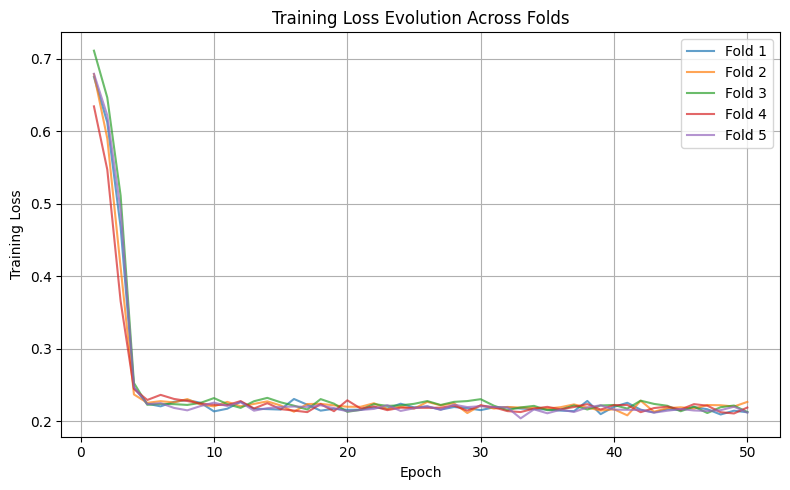

Computing metrics: 100%|██████████| 5/5 [00:00<00:00, 33.51it/s]


Mean AUC: 0.7348 +- STD0.0148
PPV: 0.0659
NPV: 0.0000
MCC: 0.0000
Spec@90: 0.4028


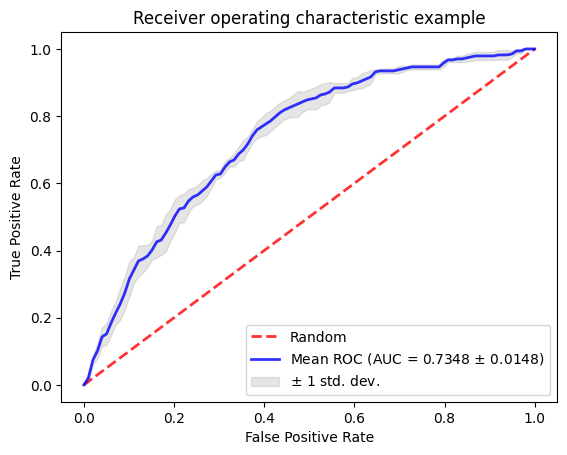

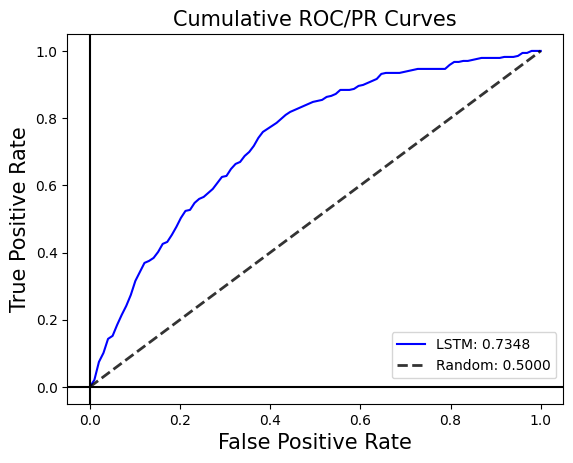


 ---- Running interpretability algorithms ---- 



Explaining features: 8it [00:01,  7.48it/s]         | 0/3 [00:00<?, ?it/s]
Explaining features: 8it [00:00, 12.61it/s]
Explaining features: 8it [00:00, 12.68it/s]
Explaining features: 8it [00:00, 13.12it/s]
Explaining features: 8it [00:00, 12.97it/s]


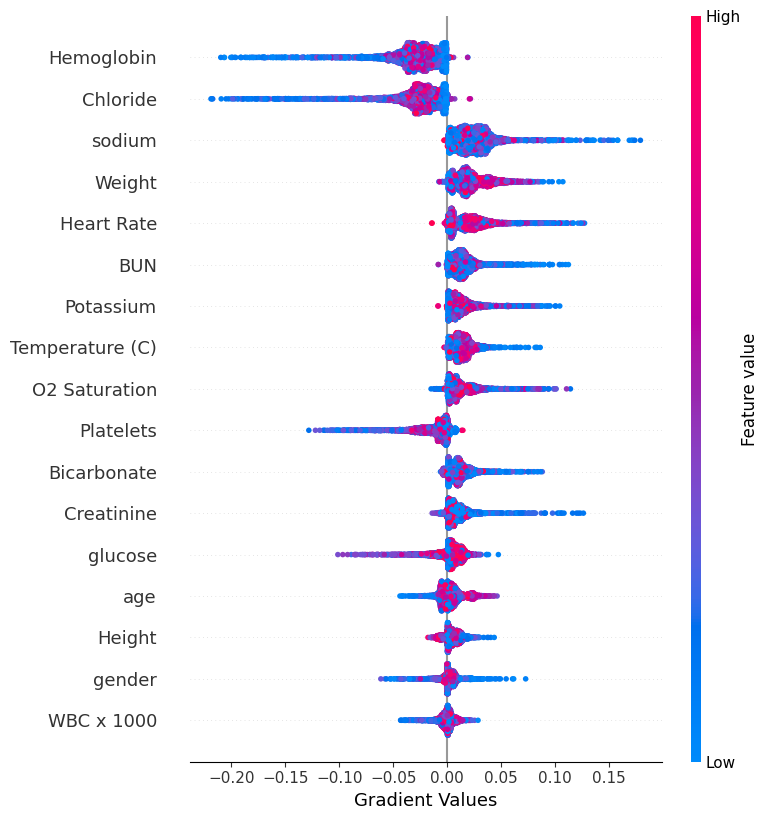

Explaining features: 8it [00:26,  3.34s/it]  ▘      | 1/3 [00:08<00:16,  8.11s/it]
Explaining features: 8it [00:27,  3.39s/it]
Explaining features: 8it [00:22,  2.83s/it]
Explaining features: 8it [00:21,  2.73s/it]
Explaining features: 8it [00:21,  2.69s/it]


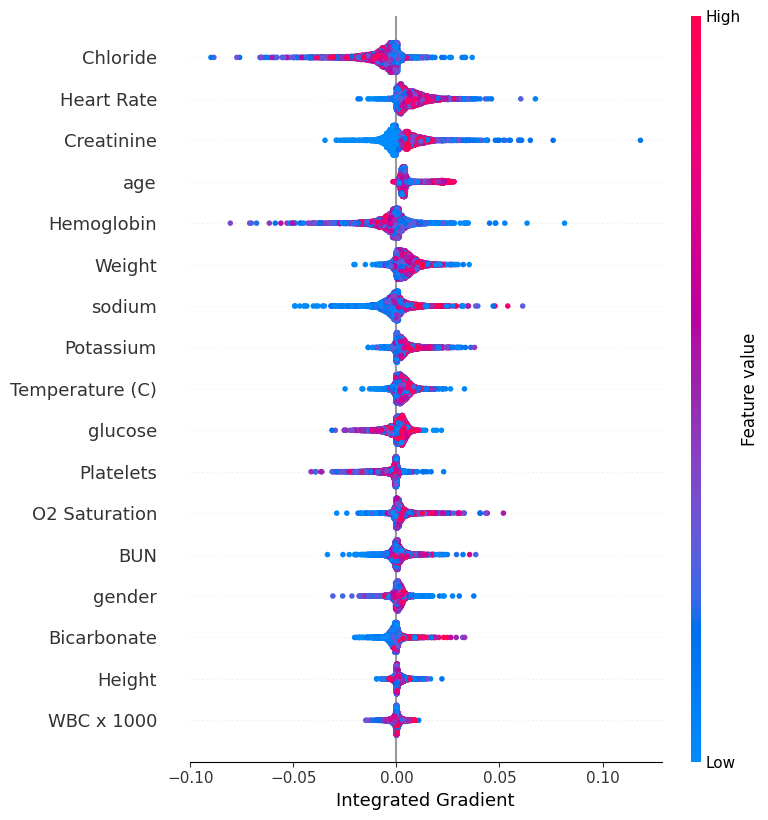

Explaining features: 8it [29:53, 224.21s/it]    ▚   | 2/3 [02:12<01:16, 76.30s/it]
Explaining features: 8it [25:31, 191.47s/it]
Explaining features: 8it [25:47, 193.46s/it]
Explaining features: 8it [24:13, 181.64s/it]
Explaining features: 8it [26:15, 196.89s/it]


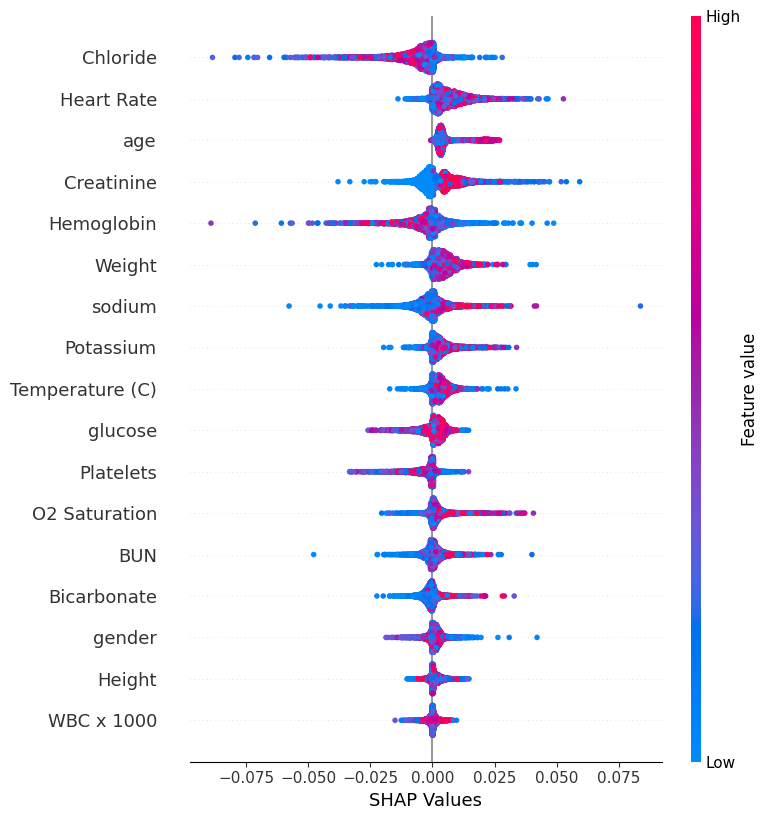

Running interpretability algorithms: 100%|          | 3/3 [2:13:58<00:00, 2679.45s/it]


In [12]:
# 9. Entry Point
logger.setLevel(logging.INFO)  # Show all levels
if __name__ == "__main__":
    min_time = 24
    skip_time = 96

    X_train, y_train, device, overdata, kwargs, cat_indices = get_eicu_feature(min_time, skip_time, n_patients=None)

    # After training, run explainability for all algorithms
    feature_names = [
        'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN',
        'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine',
        'gender', 'age'
    ]
    # Ensure X_train, y_train, device, overdata, kwargs are available in scope
    run_all_interpretability_algorithms(X_train, y_train, min_time, skip_time, device, overdata, kwargs, feature_names, cat_indices)


## MIMIC

In [17]:
#read .csv ("../Data extraction/eicu_df_all_24los_normed.csv")
df = pd.read_csv("../Data extraction/mimic_df_all_24los_normed.csv")
# Rename columns to match expected names in columns_ord
df = df.rename(columns={
    'Gender': 'gender',
    'Age': 'age',
    'Heart Rate': 'Heart Rate',
    'O2 Saturation': 'O2 Saturation',
    'Glucose': 'glucose',
    'Temperature (C)': 'Temperature (C)',
    'Sodium': 'sodium',
    'BUN': 'BUN',
    'WBC': 'WBC x 1000',
    'Hemoglobin': 'Hemoglobin',
    'Platelets': 'Platelets',
    'Potassium': 'Potassium',
    'Chloride': 'Chloride',
    'Bicarbonate': 'Bicarbonate',
    'Creatinine': 'Creatinine',
    'CAM': 'CAM',
})
df.head()

,patientunitstayid,itemoffset,gender,age,Height,Weight,Heart Rate,O2 Saturation,glucose,Temperature (C),...,Hemoglobin,Platelets,Potassium,Chloride,Bicarbonate,Creatinine,CAM,labelrec,labelpt,LOS


In [16]:
# 9.1 Entry Point Mimic
logger.setLevel(logging.DEBUG)  # Show all levels
if __name__ == "__main__":
    min_time = 24
    skip_time = 96

    X_train, y_train, device, overdata, kwargs, cat_indices = get_mimic_feature(min_time, skip_time, n_patients=500)

    # After training, run explainability for all algorithms
    feature_names = [
        'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN',
        'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine',
        'gender', 'age'
    ]
    # Ensure X_train, y_train, device, overdata, kwargs are available in scope
    run_all_interpretability_algorithms(X_train, y_train, min_time, skip_time, device, overdata, kwargs, feature_names, cat_indices)

2025-07-31 14:32:48 - INFO - [MIMIC] get_mimic_feature called with min_time=24, skip_time=96
2025-07-31 14:32:48 - DEBUG - [MIMIC] Loading data from V:\delirium\Delirium_prediction_models\Data extraction\mimic_df_all_24los_normed.csv
2025-07-31 14:32:48 - DEBUG -  pos_filtered shape: (0, 23)
2025-07-31 14:32:48 - DEBUG -  neg_filtered shape: (0, 23)
2025-07-31 14:32:48 - DEBUG -  df_filtered shape: (0, 23)
2025-07-31 14:32:48 - DEBUG -  After filtering: total patients: 0
2025-07-31 14:32:48 - DEBUG -  After filtering: patients with zero rows: 0
2025-07-31 14:32:48 - DEBUG -  After filtering: patients with all-NaN rows: 0
2025-07-31 14:32:48 - DEBUG -  Number of rows for the patient with the most rows: nan
2025-07-31 14:32:48 - DEBUG - columns_ord: ['patientunitstayid', 'itemoffset', 'gender', 'age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinin


 ---- load_eicu_data ---- 


 ---- reader_deli ---- 



Processing patients: 0it [00:00, ?it/s]
2025-07-31 14:32:48 - DEBUG - Finished. Skipped missing: 0, skipped empty: 0, processed: 0
2025-07-31 14:32:48 - DEBUG - [MIMIC] Categorical feature indices: [2], features: ['gender']
2025-07-31 14:32:48 - DEBUG - [MIMIC] Numerical feature indices: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], features: ['age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine']
2025-07-31 14:32:48 - DEBUG - [MIMIC] Label feature: CAM
2025-07-31 14:32:48 - DEBUG - [MIMIC] reader_deli output shapes: PID=(0,), X_cat=list(0), X_num=list(0), y=(0,), ts=list(0)
2025-07-31 14:32:48 - DEBUG - [MIMIC] Padding sequences to max_len=24
2025-07-31 14:32:48 - DEBUG - [MIMIC] Actual max length of sequences before padding: 0
2025-07-31 14:32:48 - DEBUG - [MIMIC] After padding: X_cat shape=(0,), X_num shape=(0,), ts shape=(0,)



 ---- Cross-validation (MIMIC) ---- 



ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

# BiRNN & DSA model

## eICU

2025-08-05 15:17:31 - INFO - eicu_pipeline called with min_time=24, skip_time=96, models=['BiRNN', 'DSA']



 ---- load_eicu_data ---- 



2025-08-05 15:17:52 - INFO - [DATA] gender unique after filtering: [1. 0.]
2025-08-05 15:17:53 - INFO - Using reduced dataset: 1000 patients
2025-08-05 15:17:53 - INFO - Data loaded successfully. train_np length: 1000, columns_ord length: 20
2025-08-05 15:17:53 - INFO - Start: 1000 patient DataFrames



 ---- reader_deli ---- 



Processing patients: 100%|██████████| 1000/1000 [00:04<00:00, 228.02it/s]
2025-08-05 15:17:57 - INFO - [DATA] categorical feature unique after pad: [0. 1.]
2025-08-05 15:17:57 - INFO - [DATA] numerical feature unique after pad: [0.         0.01408451 0.02816901 0.07042254 0.08450704 0.09859155
 0.11267606 0.12676056 0.15492958 0.16901408]
2025-08-05 15:17:57 - INFO - CAM is not present in features. No data leakage.
2025-08-05 15:17:57 - INFO - Using device: cpu
2025-08-05 15:17:57 - INFO - Instantiating model: BiRNN



 ---- Cross-validation (BiRNN) ---- 



Computing metrics (BiRNN): 100%|██████████| 5/5 [00:00<00:00, 207.23it/s]
2025-08-05 15:19:27 - INFO - Instantiating model: DSA


Mean AUC: 0.7503 +- STD0.0734
PPV: 0.0540
NPV: 0.0000
MCC: 0.0000
Spec@90: 0.5804

 ---- Cross-validation (DSA) ---- 



Computing metrics (DSA): 100%|██████████| 5/5 [00:00<00:00, 120.50it/s]


Mean AUC: 0.7705 +- STD0.0639
PPV: 0.1096
NPV: 0.9805
MCC: 0.1920
Spec@90: 0.5825


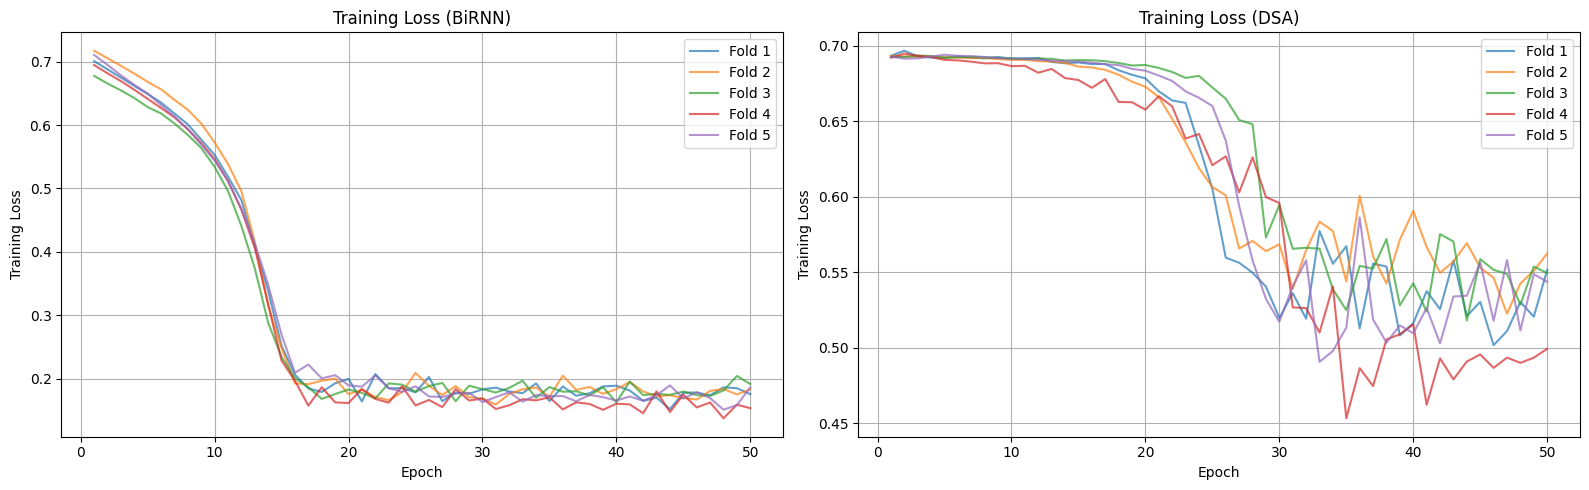


Metrics for BiRNN:
Mean AUC: 0.7503 +- STD0.0734
PPV: 0.0540
NPV: 0.0000
MCC: 0.0000
Spec@90: 0.5804

Metrics for DSA:
Mean AUC: 0.7705 +- STD0.0639
PPV: 0.1096
NPV: 0.9805
MCC: 0.1920
Spec@90: 0.5825


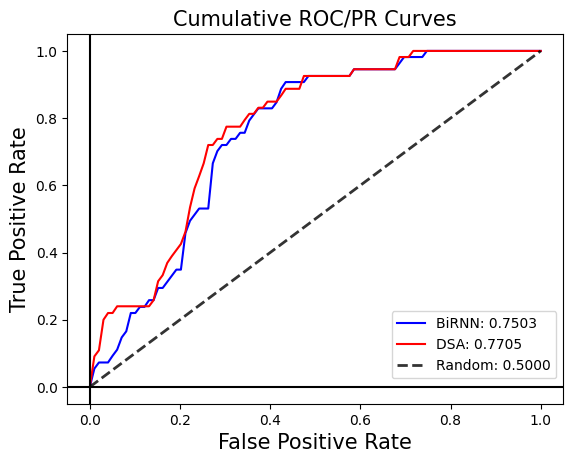


 ---- Running interpretability algorithms for multiple models ---- 


--- Interpretability for BiRNN ---
  Algorithm: GB


Explaining features: 2it [00:00, 16.73it/s]
Explaining features: 2it [00:00, 16.60it/s]
Explaining features: 2it [00:00, 17.23it/s]
Explaining features: 2it [00:00,  7.57it/s]
Explaining features: 2it [00:00, 15.03it/s]
2025-08-05 15:22:25 - WARNING - Shape mismatch: importances=(1000, 18), features=(1000, 17)
2025-08-05 15:22:25 - INFO - Removing last column from importances (likely bias term)


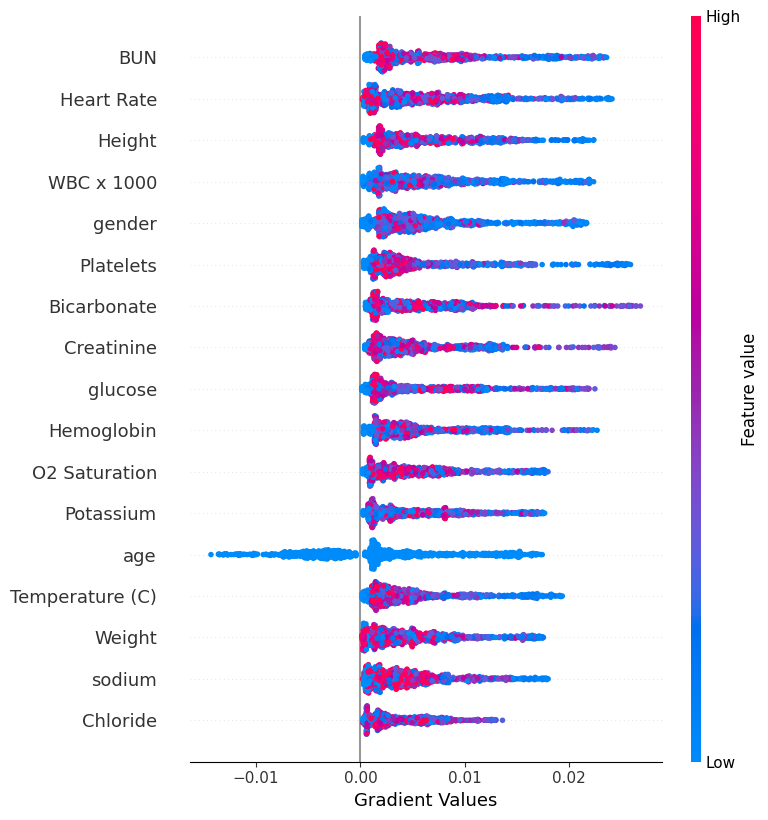

  Saved interpretability plot for BiRNN (GB) as 24min_96skip_eicu_BiRNN_GB_jama.png
  Algorithm: IG


Explaining features: 2it [00:04,  2.18s/it]
Explaining features: 2it [00:04,  2.14s/it]
Explaining features: 2it [00:03,  1.97s/it]
Explaining features: 2it [00:04,  2.36s/it]
Explaining features: 2it [00:03,  1.99s/it]
2025-08-05 15:22:48 - WARNING - Shape mismatch: importances=(1000, 18), features=(1000, 17)
2025-08-05 15:22:48 - INFO - Removing last column from importances (likely bias term)


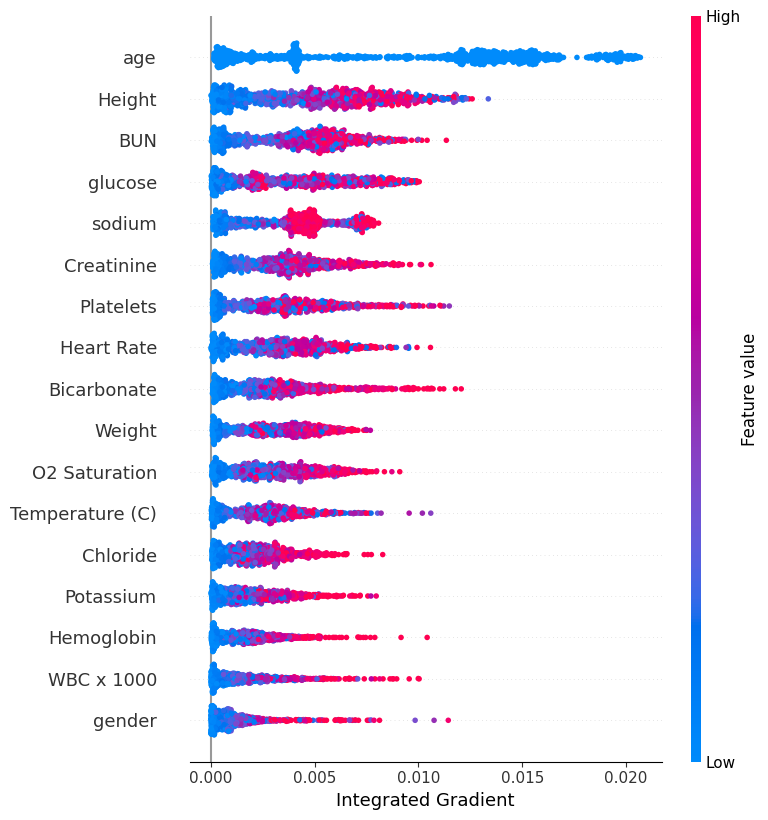

  Saved interpretability plot for BiRNN (IG) as 24min_96skip_eicu_BiRNN_IG_jama.png
  Algorithm: SVS


Explaining features: 0it [00:00, ?it/s]2025-08-05 15:22:50 - INFO - Correcting x_num_base shape for SVS: torch.Size([128, 24, 17]) -> torch.Size([128, 24, 16])
Explaining features: 1it [03:09, 189.56s/it]2025-08-05 15:26:00 - INFO - Correcting x_num_base shape for SVS: torch.Size([72, 24, 17]) -> torch.Size([72, 24, 16])
Explaining features: 2it [05:03, 151.97s/it]
Explaining features: 0it [00:00, ?it/s]2025-08-05 15:27:54 - INFO - Correcting x_num_base shape for SVS: torch.Size([128, 24, 17]) -> torch.Size([128, 24, 16])
Explaining features: 1it [02:34, 154.67s/it]2025-08-05 15:30:29 - INFO - Correcting x_num_base shape for SVS: torch.Size([72, 24, 17]) -> torch.Size([72, 24, 16])
Explaining features: 2it [04:21, 130.65s/it]
Explaining features: 0it [00:00, ?it/s]2025-08-05 15:32:15 - INFO - Correcting x_num_base shape for SVS: torch.Size([128, 24, 17]) -> torch.Size([128, 24, 16])
Explaining features: 1it [02:53, 173.59s/it]2025-08-05 15:40:04 - INFO - Correcting x_num_base shape for

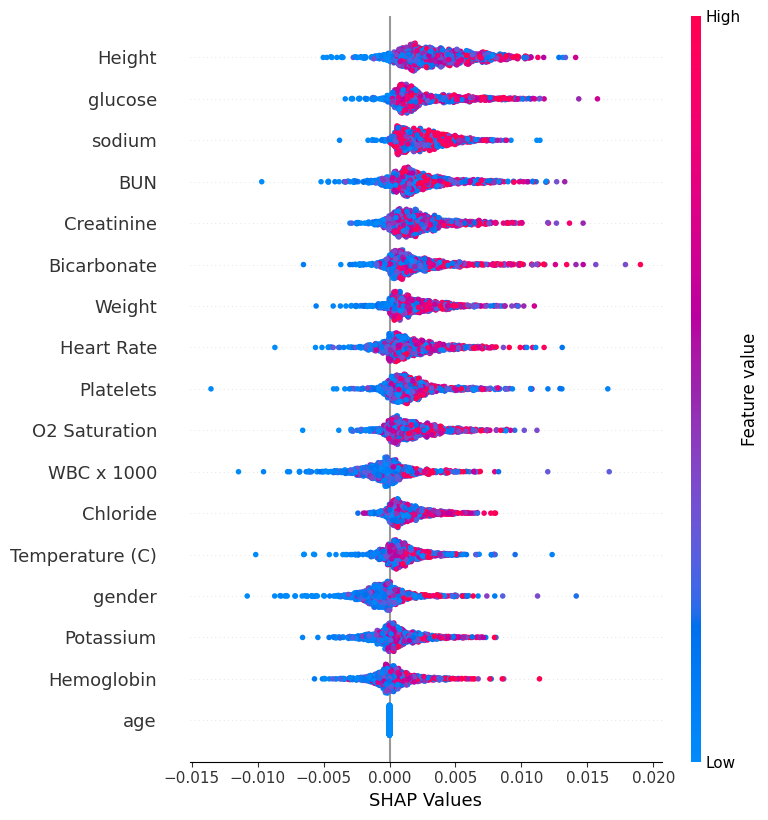

  Saved interpretability plot for BiRNN (SVS) as 24min_96skip_eicu_BiRNN_SVS_jama.png

--- Interpretability for DSA ---
  Algorithm: GB


Explaining features: 2it [00:00, 14.67it/s]
Explaining features: 2it [00:00, 19.68it/s]
Explaining features: 2it [00:00, 18.86it/s]
Explaining features: 2it [00:00, 17.74it/s]
Explaining features: 2it [00:00, 20.05it/s]
2025-08-05 15:46:51 - WARNING - Shape mismatch: importances=(1000, 18), features=(1000, 17)
2025-08-05 15:46:51 - INFO - Removing last column from importances (likely bias term)


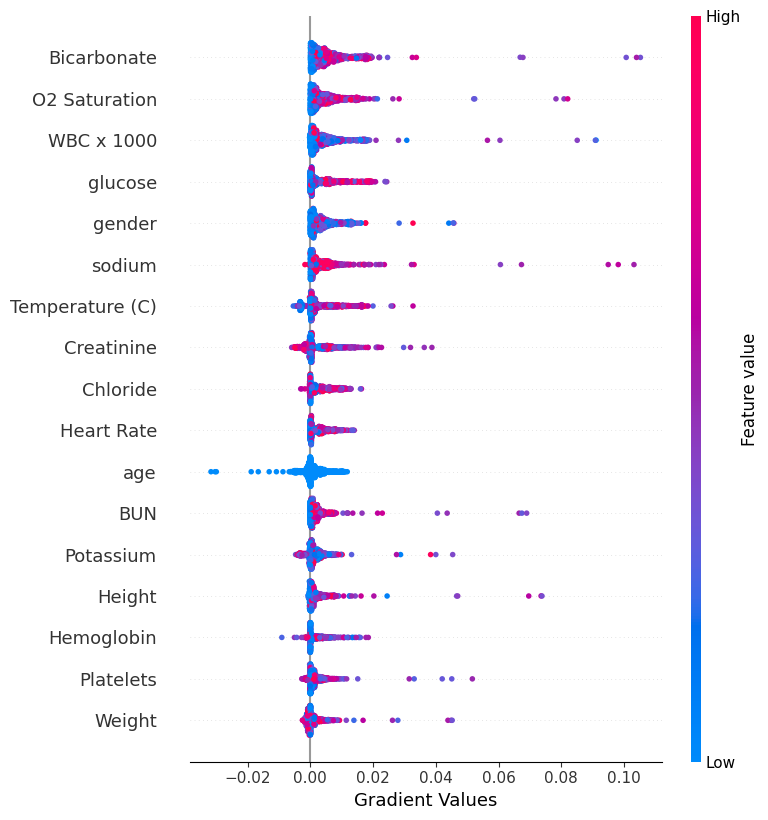

  Saved interpretability plot for DSA (GB) as 24min_96skip_eicu_DSA_GB_jama.png
  Algorithm: IG


Explaining features: 2it [00:04,  2.44s/it]
Explaining features: 2it [00:04,  2.19s/it]
Explaining features: 2it [00:04,  2.10s/it]
Explaining features: 2it [00:04,  2.13s/it]
Explaining features: 2it [00:03,  1.94s/it]
2025-08-05 15:47:14 - WARNING - Shape mismatch: importances=(1000, 18), features=(1000, 17)
2025-08-05 15:47:14 - INFO - Removing last column from importances (likely bias term)


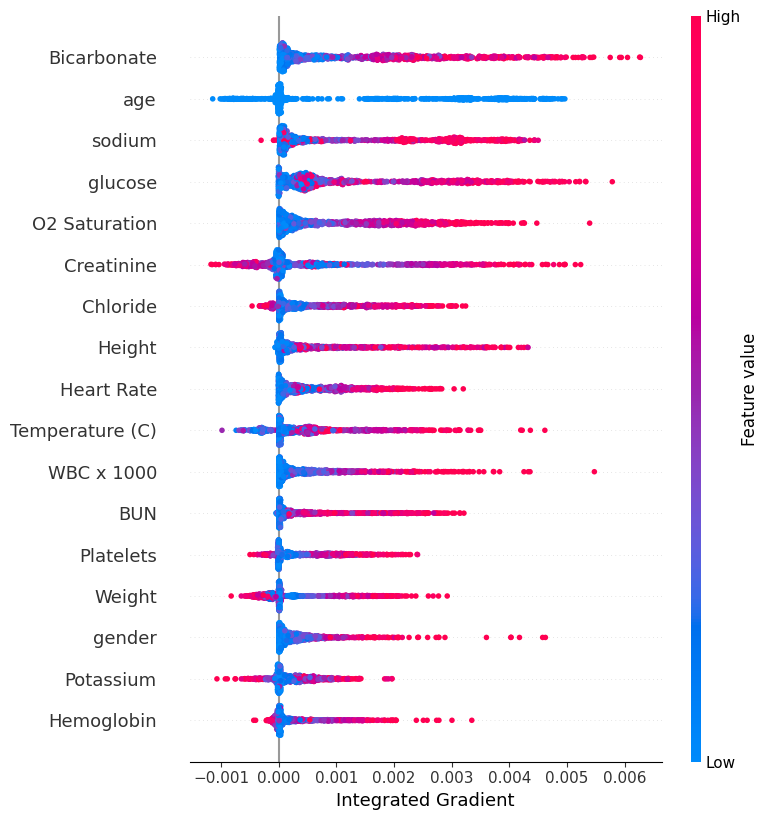

  Saved interpretability plot for DSA (IG) as 24min_96skip_eicu_DSA_IG_jama.png
  Algorithm: SVS


Explaining features: 0it [00:00, ?it/s]2025-08-05 15:47:16 - INFO - Correcting x_num_base shape for SVS: torch.Size([128, 24, 17]) -> torch.Size([128, 24, 16])
Explaining features: 2it [06:11, 185.75s/it]
Explaining features: 0it [00:00, ?it/s]2025-08-05 15:53:28 - INFO - Correcting x_num_base shape for SVS: torch.Size([128, 24, 17]) -> torch.Size([128, 24, 16])
Explaining features: 1it [04:04, 244.39s/it]2025-08-05 15:57:32 - INFO - Correcting x_num_base shape for SVS: torch.Size([72, 24, 17]) -> torch.Size([72, 24, 16])
Explaining features: 2it [06:48, 204.20s/it]
Explaining features: 0it [00:00, ?it/s]2025-08-05 16:00:16 - INFO - Correcting x_num_base shape for SVS: torch.Size([128, 24, 17]) -> torch.Size([128, 24, 16])
Explaining features: 1it [03:58, 238.57s/it]2025-08-05 16:04:15 - INFO - Correcting x_num_base shape for SVS: torch.Size([72, 24, 17]) -> torch.Size([72, 24, 16])
Explaining features: 2it [06:47, 203.89s/it]
Explaining features: 0it [00:00, ?it/s]2025-08-05 16:07:04 

In [ ]:
# 9. Entry Point
logger.setLevel(logging.INFO)  # Show all levels
if __name__ == "__main__":
    min_time = 24
    skip_time = 96
    results, X_train, y_train, device, overdata, kwargs, cat_indices = eicu_pipeline(
        min_time, skip_time, n_patients=1000, models=[
            ("BiRNN", BiRNN),
            ("DSA", DSA),
        ]
    )

    feature_names = [
        'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN',
        'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine',
        'gender', 'age'
    ]

    # Interpret all models:
    run_all_interpretability_algorithms_multi(
        results, X_train, y_train, min_time, skip_time, device, overdata, kwargs, feature_names, cat_indices,
        algo=["GB", "IG", "SVS"],  # Specify algorithms to run
        models_to_interpret=["BiRNN", "DSA"]  # or None for all # BiRNN
    )

2025-07-31 16:55:47 - INFO - eicu_pipeline called with min_time=24, skip_time=96, models=['BiRNN', 'DSA']



 ---- load_eicu_data ---- 



2025-07-31 16:56:54 - DEBUG -  pos_filtered shape: (6606, 23)
2025-07-31 16:56:54 - DEBUG -  neg_filtered shape: (68603, 23)
2025-07-31 16:56:54 - DEBUG -  df_filtered shape: (75209, 23)
2025-07-31 16:56:56 - DEBUG -  After filtering: total patients: 5100
2025-07-31 16:56:56 - DEBUG -  After filtering: patients with zero rows: 0
2025-07-31 16:56:56 - DEBUG -  After filtering: patients with all-NaN rows: 0
2025-07-31 16:56:56 - DEBUG -  Number of rows for the patient with the most rows: 23
2025-07-31 16:56:56 - DEBUG - columns_ord: ['patientunitstayid', 'itemoffset', 'gender', 'age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine', 'CAM']
2025-07-31 16:56:56 - INFO - Data loaded successfully. train_np length: 5100, columns_ord length: 20
2025-07-31 16:56:56 - INFO - Start: 5100 patient DataFrames



 ---- reader_deli ---- 



Processing patients: 100%|██████████| 5100/5100 [00:27<00:00, 188.70it/s]
2025-07-31 16:57:23 - DEBUG - Finished. Skipped missing: 0, skipped empty: 0, processed: 5100
2025-07-31 16:57:23 - DEBUG - Categorical feature indices: [2], features: ['gender']
2025-07-31 16:57:23 - DEBUG - Numerical feature indices: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], features: ['age', 'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN', 'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine']
2025-07-31 16:57:23 - DEBUG - Label feature: CAM
2025-07-31 16:57:23 - DEBUG - reader_deli output shapes: PID=(5100,), X_cat=list(5100), X_num=list(5100), y=(5100,), ts=list(5100)
2025-07-31 16:57:23 - DEBUG - Padding sequences to max_len=24
2025-07-31 16:57:23 - DEBUG - Actual max length of sequences before padding: 23
2025-07-31 16:57:23 - DEBUG - After padding: X_cat shape=(5100, 24, 3), X_num shape=(5100, 24, 14)


 ---- Cross-validation (BiRNN) ---- 



Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]2025-07-31 16:57:23 - DEBUG - Fold: 1
2025-07-31 16:57:25 - DEBUG - Epoch: 1/50 Training Loss: 0.675
2025-07-31 16:57:46 - DEBUG - Epoch: 10/50 Training Loss: 0.214
2025-07-31 16:58:08 - DEBUG - Epoch: 20/50 Training Loss: 0.216
2025-07-31 16:58:30 - DEBUG - Epoch: 30/50 Training Loss: 0.216
2025-07-31 16:58:51 - DEBUG - Epoch: 40/50 Training Loss: 0.220
2025-07-31 16:59:13 - DEBUG - Epoch: 50/50 Training Loss: 0.213
2025-07-31 16:59:13 - DEBUG - Model:eicu_18_128_fold_1_cv_torch.pt saved.
Cross-validation:  20%|██        | 1/5 [01:50<07:20, 110.09s/it]2025-07-31 16:59:13 - DEBUG - Fold: 2
2025-07-31 16:59:16 - DEBUG - Epoch: 1/50 Training Loss: 0.679
2025-07-31 16:59:36 - DEBUG - Epoch: 10/50 Training Loss: 0.221
2025-07-31 16:59:58 - DEBUG - Epoch: 20/50 Training Loss: 0.220
2025-07-31 17:00:20 - DEBUG - Epoch: 30/50 Training Loss: 0.222
2025-07-31 17:00:43 - DEBUG - Epoch: 40/50 Training Loss: 0.217
2025-07-31 17:01:05 - DEBUG -

Mean AUC: 0.7348 +- STD0.0148
PPV: 0.0659
NPV: 0.0000
MCC: 0.0000
Spec@90: 0.4028

 ---- Cross-validation (DSA) ---- 



Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]2025-07-31 17:07:01 - DEBUG - Fold: 1
2025-07-31 17:07:06 - DEBUG - Epoch: 1/50 Training Loss: 0.693
2025-07-31 17:07:37 - DEBUG - Epoch: 10/50 Training Loss: 0.610
2025-07-31 17:08:07 - DEBUG - Epoch: 20/50 Training Loss: 0.594
2025-07-31 17:08:35 - DEBUG - Epoch: 30/50 Training Loss: 0.584
2025-07-31 17:09:03 - DEBUG - Epoch: 40/50 Training Loss: 0.598
2025-07-31 17:09:31 - DEBUG - Epoch: 50/50 Training Loss: 0.583
2025-07-31 17:09:31 - DEBUG - Model:eicu_18_128_fold_1_cv_torch.pt saved.
Cross-validation:  20%|██        | 1/5 [02:30<10:01, 150.40s/it]2025-07-31 17:09:31 - DEBUG - Fold: 2
2025-07-31 17:09:34 - DEBUG - Epoch: 1/50 Training Loss: 0.693
2025-07-31 17:09:59 - DEBUG - Epoch: 10/50 Training Loss: 0.617
2025-07-31 17:10:28 - DEBUG - Epoch: 20/50 Training Loss: 0.599
2025-07-31 17:10:55 - DEBUG - Epoch: 30/50 Training Loss: 0.602
2025-07-31 17:11:23 - DEBUG - Epoch: 40/50 Training Loss: 0.602
2025-07-31 17:11:50 - DEBUG -

Mean AUC: 0.7331 +- STD0.0091
PPV: 0.1191
NPV: 0.9710
MCC: 0.1783
Spec@90: 0.3740


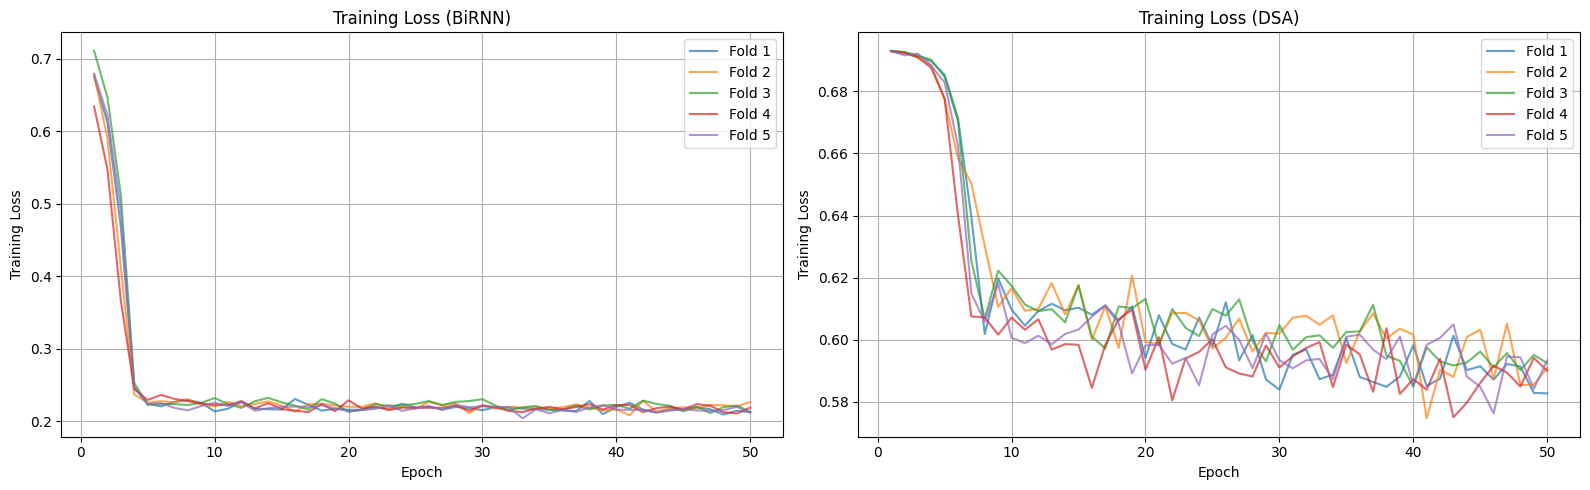


Metrics for BiRNN:
Mean AUC: 0.7348 +- STD0.0148
PPV: 0.0659
NPV: 0.0000
MCC: 0.0000
Spec@90: 0.4028

Metrics for DSA:
Mean AUC: 0.7331 +- STD0.0091
PPV: 0.1191
NPV: 0.9710
MCC: 0.1783
Spec@90: 0.3740


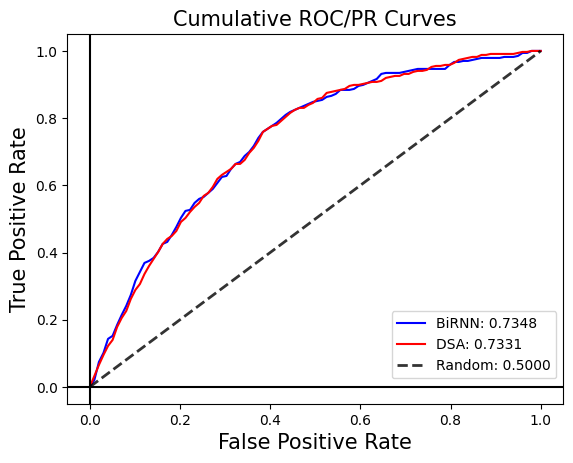

: 

In [ ]:
# 9. Entry Point
logger.setLevel(logging.DEBUG)  # Show all levels
if __name__ == "__main__":
    min_time = 24
    skip_time = 96
    results, X_train, y_train, device, overdata, kwargs, cat_indices = eicu_pipeline(
        min_time, skip_time, n_patients=None, models=[
            ("BiRNN", BiRNN),
            ("DSA", DSA),
        ]
    )

    # If you want to run interpretability, uncomment below
    # feature_names = [
    #     'Height', 'Weight', 'Heart Rate', 'O2 Saturation', 'glucose', 'Temperature (C)', 'sodium', 'BUN',
    #     'WBC x 1000', 'Hemoglobin', 'Platelets', 'Potassium', 'Chloride', 'Bicarbonate', 'Creatinine',
    #     'gender', 'age'
    # ]
    # run_all_interpretability_algorithms(X_train, y_train, min_time, skip_time, device, overdata, kwargs, feature_names, cat_indices)